In [12]:
from tams_pr2_guzheng.paths import RuckigPath
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import scipy.stats as stats
import seaborn as sns

In [4]:
%load_ext autoreload
%autoreload 1
import sys
if 'utils' not in sys.path:
    sys.path.append('utils')
import u
%aimport u

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
p = RuckigPath.random(note= 'c4', string_position= 0.13, direction= -1.0)
#p.dataframe().plot(x="time", style="")
ax= plt.figure().gca()
ax.plot([0.0], [0.0], "o")
ax.set_xlim(*sorted((p.pre[0], p.post[0])))
ax.set_ylim(*sorted((p.pre[1], p.post[1], -0.01)))
p.dataframe.plot(x="y", y="z", legend=None, ax=ax)

In [ ]:
NN= 20
Nmu = np.linspace(0.0, 1.0, NN)
Nsigma = np.linspace(0.3, 0.03, NN)

In [ ]:
N= stats.norm(loc=Nmu, scale= Nsigma)

stats.norm.pdf(0.0, loc=Nmu, scale= Nsigma)

In [ ]:
plt.plot(np.arange(NN), N.pdf(0.5));

In [41]:
D=pd.read_json('/tmp/plucks.json')

In [42]:
D.columns

Index(['string', 'max_vel_y', 'max_vel_z', 'max_acc_y', 'max_acc_z',
       'max_jerk_y', 'max_jerk_z', 'pre_y', 'pre_z', 'post_y', 'post_z',
       'keypoint_pos_y', 'keypoint_pos_z', 'keypoint_vel_y', 'keypoint_vel_z',
       'string_position', 'finger', 'loudness', 'detected_note', 'onset_cnt',
       'onsets'],
      dtype='object')

In [43]:
X=D[['string', 'pre_y', 'loudness']]

In [44]:
X= X.sort_values('string', key= lambda x: x.map(lambda a: librosa.note_to_midi(u.string_to_note(a))))

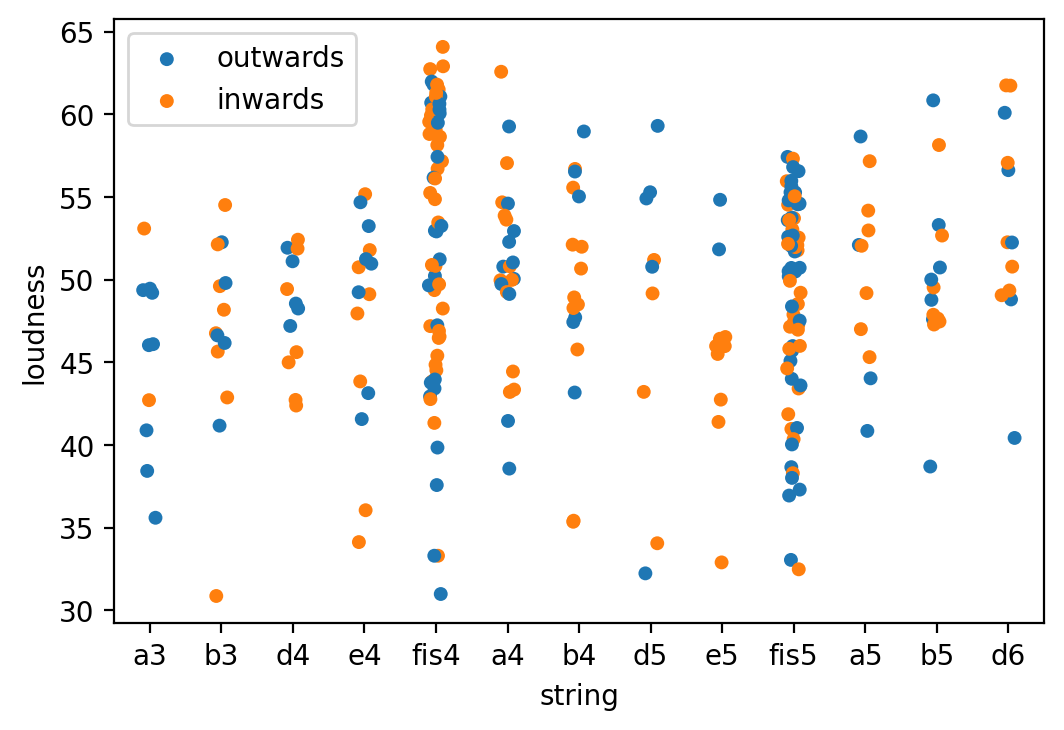

In [45]:
plt.figure(dpi=200)
ax = sns.stripplot(x=X['string'], y=X['loudness'], hue= X['pre_y']);
ax.legend(['outwards', 'inwards']);